In [1]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from suite3d import nbtools as nbui

In [22]:


tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

In [24]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-07-27',
    'expnum' :         [13,14,]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21]),
    # number of files to use for the initial pass
    'n_init_files' :   1,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 7,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : True,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str + 'subset', tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset already exists
Loading job directory for AH012_2024-07-27_13-14subset in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [15]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/AH012/2024-07-27/13/2024-07-27_13_AH012_2P_00001_00011.tif
    Loaded file into shared memory in 20.42 sec
    Workers completed in 1.37 sec
    Total time: 21.80 sec
   Loaded 1 files, total 2.90 GB
   Loaded movie with 100 frames and shape 24, 900, 720
      Enforcing positivity in mean image
Estiamted crosstalk in 9.422762393951416s


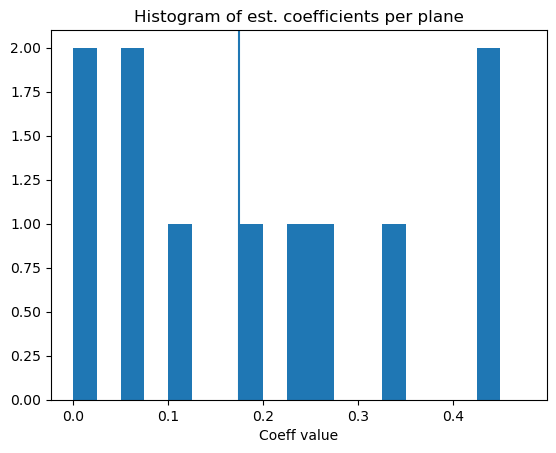

MovieWriter ffmpeg unavailable; using Pillow instead.


   Subtracting with estimated coefficient 0.175
         Subtracting plane 0 from 13
         Subtracting plane 1 from 14
         Subtracting plane 2 from 15
         Subtracting plane 3 from 16
         Subtracting plane 4 from 17
         Subtracting plane 5 from 18
         Subtracting plane 6 from 19
         Subtracting plane 7 from 20
         Subtracting plane 8 from 21
         Subtracting plane 9 from 22
         Subtracting plane 10 from 23
[{'uid': '9A1B7D0F2A67F484', 'center': array([0, 0]), 'sizeXY': array([ 2.7  , 16.875]), 'pixXY': array([144, 900])}, {'uid': 'D13AC8ABC660883F', 'center': array([2.7, 0. ]), 'sizeXY': array([ 2.7  , 16.875]), 'pixXY': array([144, 900])}, {'uid': '66DCE42C83645264', 'center': array([5.4, 0. ]), 'sizeXY': array([ 2.7  , 16.875]), 'pixXY': array([144, 900])}, {'uid': '18B13E686766C950', 'center': array([0, 0]), 'sizeXY': array([ 2.7  , 16.875]), 'pixXY': array([144, 900])}, {'uid': '305F5B1ABEA43014', 'center': array([-2.7,  0. ]), 'sizeXY'

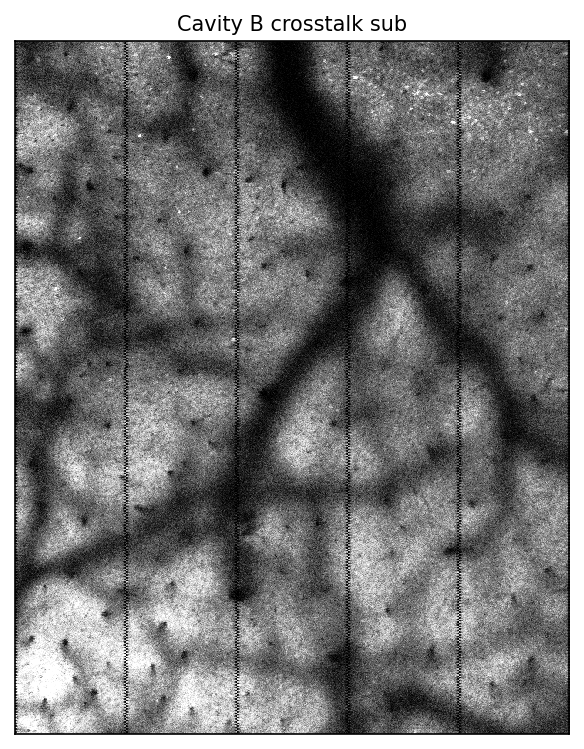

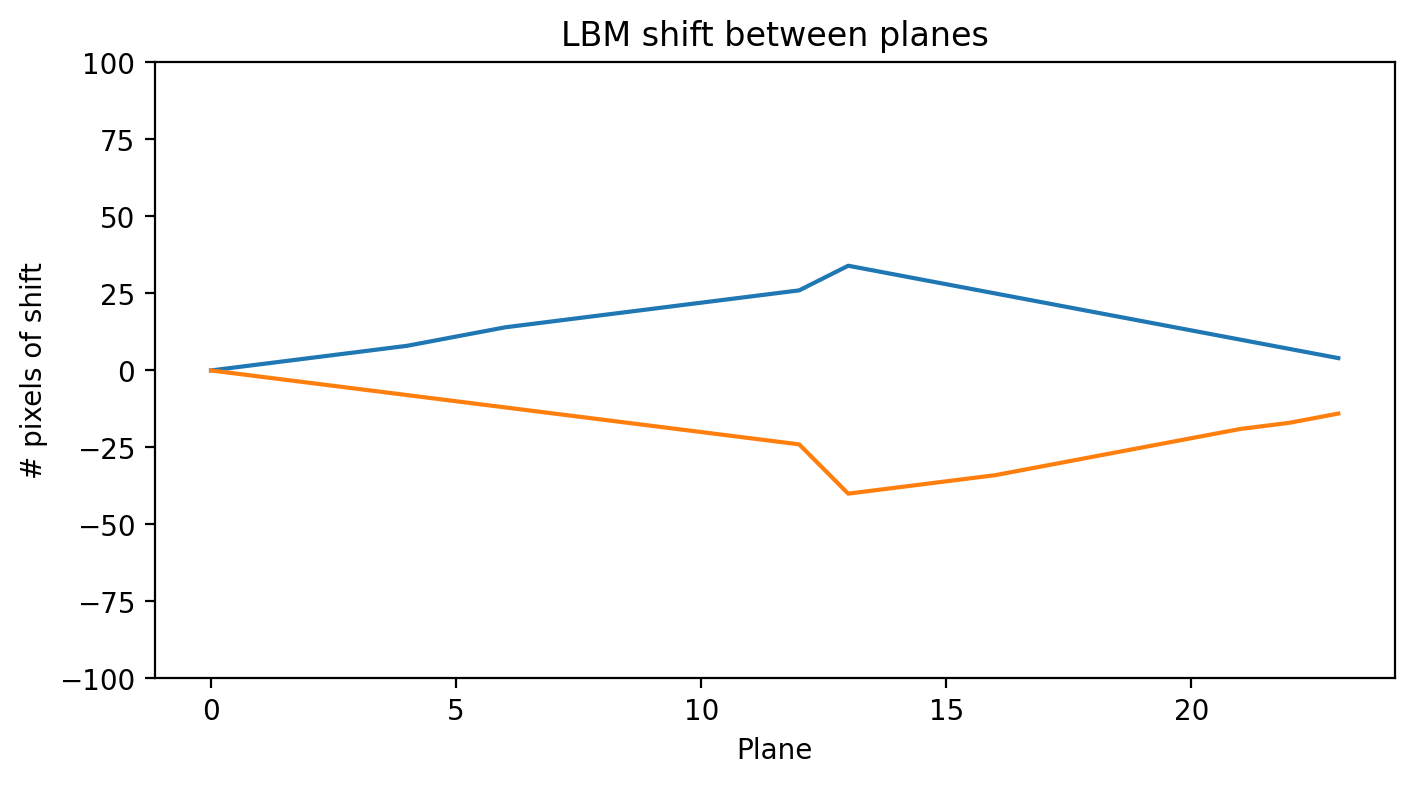

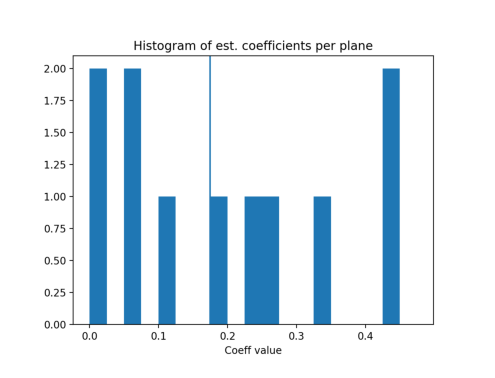

In [16]:
%%time
job.run_init_pass()

In [19]:
img3d = job.load_summary()['ref_img_3d']

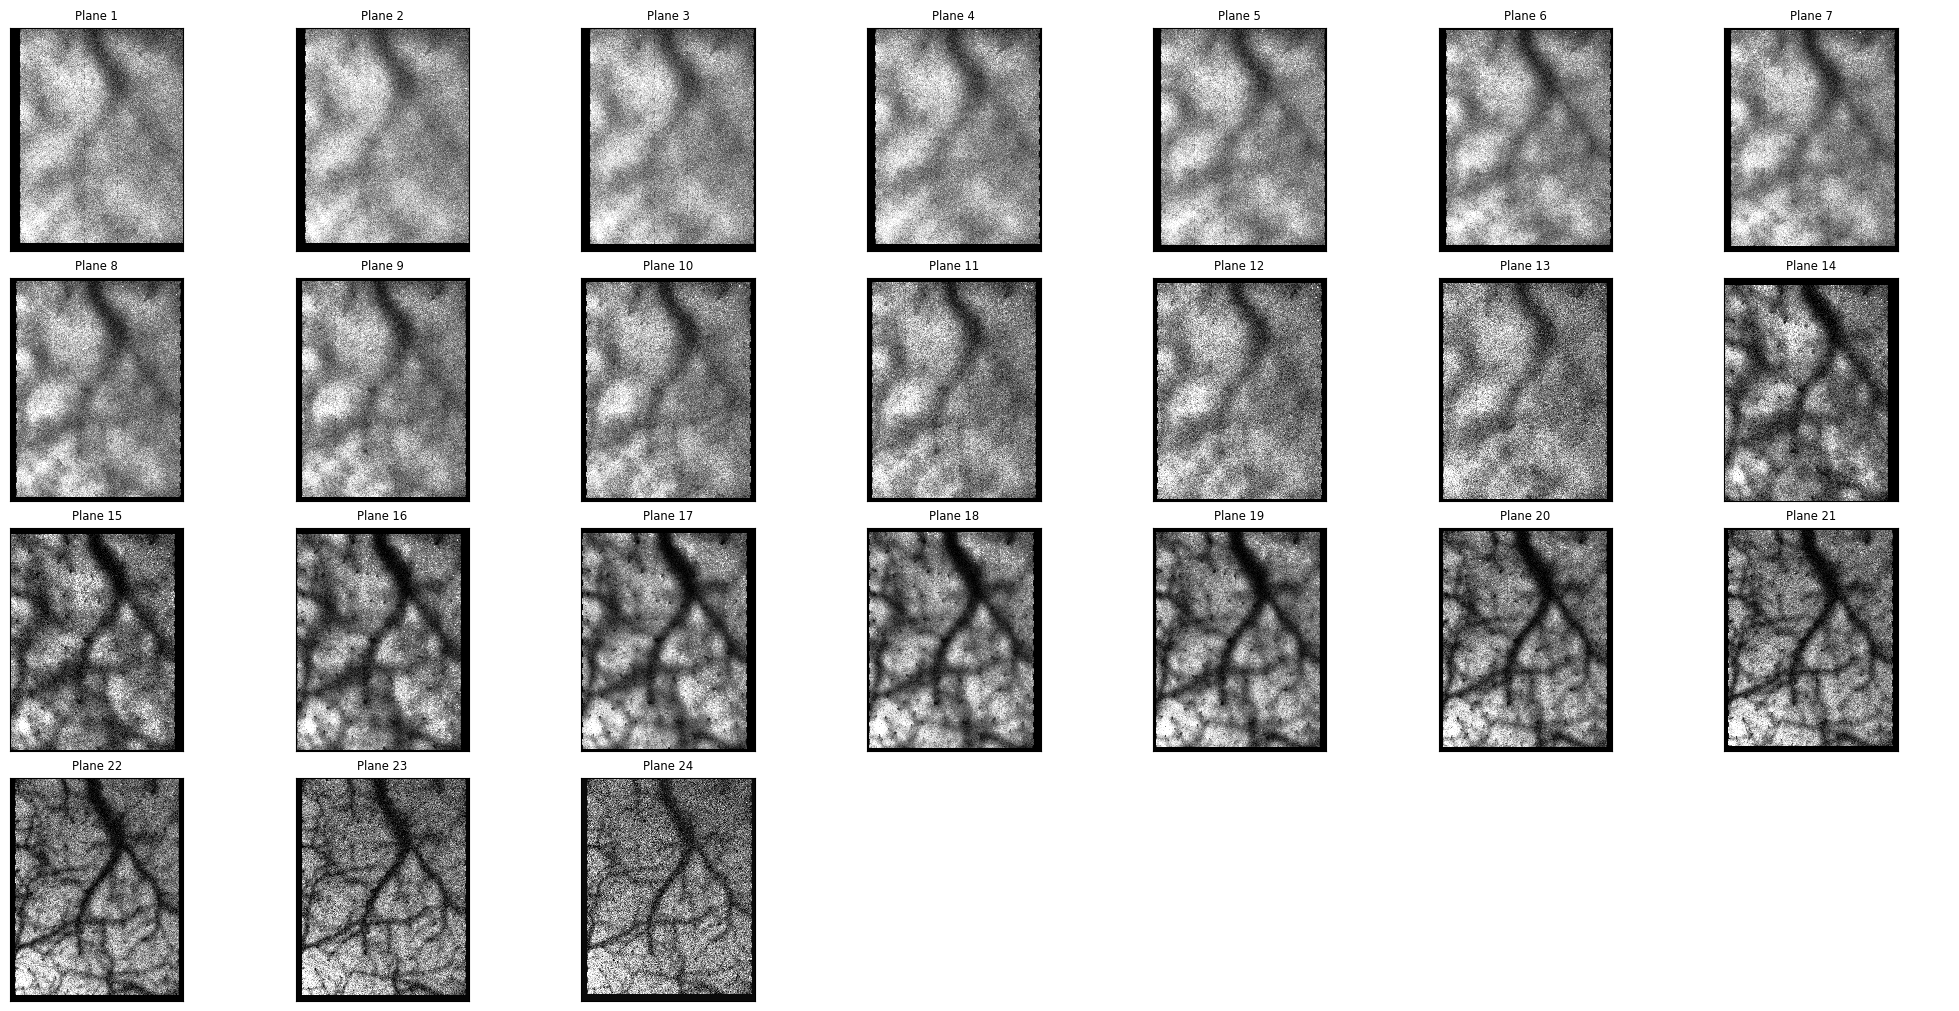

In [20]:
tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,10))

In [26]:
job.tifs[-4:]

['/mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00005.tif',
 '/mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00006.tif',
 '/mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00007.tif',
 '/mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00008.tif']

In [29]:
%%time
job.register(tifs=job.tifs[-4:])

      Found dir /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Overriding fuse shift value to 7
   Not clipping frames for registration
Will analyze 4 tifs in 4 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 107.677 GB, Virtual Available: 411.203 GB, Virtual Used: 091.992 GB, Swap Used: 015.684 GB
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00005.tif
Loading Batch 0 of 3
    Loaded file into shared memory in 24.76 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.03 sec
    Total time: 26.79 sec
   Loaded 1 files, total 2.90 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 110.604 GB, Virtual Available: 408.276 GB, Virtual Used: 094.920 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 113.504 GB, Virtual Available: 405.376 GB, Virtual Used: 097.820 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 104.043 GB, Virtual Available: 414.837 GB, Virtual Used: 088.359 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 104.043 GB, Virtual Available: 414.837 GB, Virtual Used: 088.359 GB, Swap Used: 015.684 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00006.tif


NameError: name 'utils' is not defined

    Loaded file into shared memory in 24.51 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.98 sec
    Total time: 26.49 sec
   Loaded 1 files, total 2.90 GB


In [28]:
reg = job.load_registration_results()

IndexError: list index out of range

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st